# Predicting Energy Usage of a Power Plant

Importing necessary packages and reading the data.

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [253]:
df = pd.read_csv('./data/coursework_other.csv')

The next three blocks examine the raw data, check for any missing data, and see if there are any outliers for any of the variables.

In [254]:
df

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


In [255]:
df.isnull().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

No missing data.

In [256]:
df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


The next block graphs each of the input features against the target variable (PE) to investigate any clear correlation.

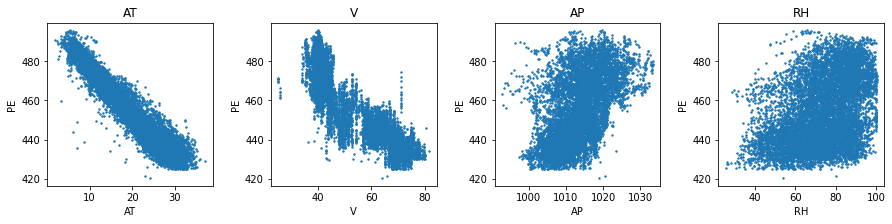

In [257]:
variables = ['AT', 'V', 'AP', 'RH']  # input features
fig, ax = plt.subplots(1, 4, figsize=(15,3))
for i in range(4):
    ax[i].scatter(df[variables[i]], df['PE'], s=2)
    ax[i].set_xlabel(variables[i])
    ax[i].set_ylabel('PE')
    ax[i].set_title(variables[i])
    plt.subplots_adjust(wspace=0.35)

## Baseline Model

The following two blocks train the baseline model on the training set and report the RMSE and R2 on the test set. The second block visualises the function.

In [258]:
from sklearn.linear_model import LinearRegression

X = df['AT'].to_numpy().reshape(-1, 1)  # reshape for model input
y = df['PE']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=77)  # split the data into train and test sets using a random state to ensure reproducibility and the same split throughout the project.

lin_reg = LinearRegression()  # instantiate the model
lin_reg.fit(Xtrain, ytrain)  # fit model
ypred_lr = lin_reg.predict(Xtest)  # predict the test set

rmse_lr = np.sqrt(mean_squared_error(ytest, ypred_lr))  # calculate RMSE from MSE
r2_lr = r2_score(ytest, ypred_lr)

print(f'Baseline Model (Linear Regression) Results\nRMSE: {rmse_lr}\nR2: {r2_lr}')

Baseline Model (Linear Regression) Results
RMSE: 5.37394146839196
R2: 0.9023997050475004


Text(0, 0.5, 'PE')

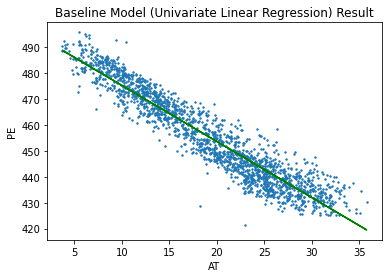

In [259]:
fig, ax = plt.subplots(1, 1)
ax.scatter(x=Xtest, y=ytest, s=2)
ax.plot(Xtest, lin_reg.coef_[0]*Xtest + lin_reg.intercept_, color='g')
ax.set_title('Baseline Model (Univariate Linear Regression) Result')
ax.set_xlabel('AT')
ax.set_ylabel('PE')

## Random Forest Regressor Hyperparameter Selection

10-fold cross-validation to obtain optimal maximum tree depth (D) for the random forest regressor. The block below sets up the 10 folds with random state to ensure the same folds are used for the MLP hyperparameter selection.

In [260]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=77, shuffle=True)

In [261]:
from sklearn.ensemble import RandomForestRegressor

max_d = 20  # maximum D

X = df[['AT', 'V', 'AP', 'RH']].to_numpy()
y = df['PE'].to_numpy()

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=77)  # same train/test split as before.

mses_train = [[] for _ in range(max_d)]
mses_val = [[] for _ in range(max_d)]


for d in range(max_d):

    rf = RandomForestRegressor(max_depth=d+1, random_state=77)  # instatiate the random forest model with current D being tested.

    for train_index, val_index in kf.split(Xtrain):
        Xtr, Xval = Xtrain[train_index], Xtrain[val_index]
        ytr, yval = ytrain[train_index], ytrain[val_index]

        rf.fit(Xtr, ytr)

        ypred_rf_train = rf.predict(Xtr)
        ypred_rf_val = rf.predict(Xval)

        mses_train[d].append(mean_squared_error(ytr, ypred_rf_train))  # calculate the MSE for the train set.
        mses_val[d].append(mean_squared_error(yval, ypred_rf_val))  # calculate the MSE for the val set.

In [262]:
rmse_fold_means_train_rf = []
rmse_fold_means_val_rf = []

for i in range(len(mses_val)):
    rmse_fold_means_train_rf.append(np.sqrt(np.mean(mses_train[i])))  # these two lines take the mean of the fold results for each hyperparameter setting and then takes the square root to convert MSE to RMSE.
    rmse_fold_means_val_rf.append(np.sqrt(np.mean(mses_val[i])))

The next block plots maximum tree depth against the respective RMSE to attain the optimal D value.

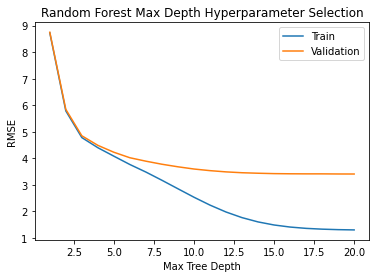

In [263]:
x = np.linspace(1, 20, num=20)

fig, ax = plt.subplots(1, 1)
sns.lineplot(x=x, y=rmse_fold_means_train_rf, ax=ax, label='Train')
sns.lineplot(x=x, y=rmse_fold_means_val_rf, ax=ax, label='Validation')
ax.set_title(f'Random Forest Max Depth Hyperparameter Selection')
ax.set_ylabel('RMSE')
ax.set_xlabel('Max Tree Depth')
ax.legend(loc='best')

Optimal D = 14.

## Multi-layer Perceptron Hyperparameter Selection

The next block uses cross validation to attain the optimal number of layers and neurons in each uniform layer.

In [264]:
from sklearn.neural_network import MLPRegressor

X = df[['AT', 'V', 'AP', 'RH']].to_numpy()
y = df['PE'].to_numpy()

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=77)  # same train/test split.

max_layers = 3  # maximum number of hidden layers.
neurons = np.linspace(10, 150, 15)  # maximum number of neurons in each hidden layer 10-150.

mses_train_nn_1 = [[[] for _ in range(15)] for _ in range(max_layers)]  # nested cross-validation set up.
mses_val_nn_1 = [[[] for _ in range(15)] for _ in range(max_layers)]

for i in range(max_layers):
    for j, n in enumerate(neurons):
        
        hidden_layer = np.array([int(n) for _ in range(i+1)])  # sets up the hidden_layer parameter using the current number of layers and number of neurons being tested.
        mlp = MLPRegressor(alpha=1, hidden_layer_sizes=hidden_layer, max_iter=1000, random_state=77)  # instantiate the MLP.
        
        fold = 0
        
        for train_index, val_index in kf.split(Xtrain):
            Xtr, Xval = Xtrain[train_index], Xtrain[val_index]
            ytr, yval = ytrain[train_index], ytrain[val_index]
            
            mlp.fit(Xtr, ytr)
            
            ypred_mlp_train = mlp.predict(Xtr)
            ypred_mlp_val = mlp.predict(Xval)

            mses_train_nn_1[i][j].append(mean_squared_error(ytr, ypred_mlp_train))  # calculate the MSE for the train set.
            mses_val_nn_1[i][j].append(mean_squared_error(yval, ypred_mlp_val))  # calculate the MSE for the val set.

            fold += 1
            print('done', i+1, n, fold)

done 1 10.0 1
done 1 10.0 2
done 1 10.0 3
done 1 10.0 4
done 1 10.0 5
done 1 10.0 6
done 1 10.0 7
done 1 10.0 8
done 1 10.0 9
done 1 10.0 10
done 1 20.0 1
done 1 20.0 2
done 1 20.0 3
done 1 20.0 4
done 1 20.0 5
done 1 20.0 6
done 1 20.0 7
done 1 20.0 8
done 1 20.0 9
done 1 20.0 10
done 1 30.0 1
done 1 30.0 2
done 1 30.0 3
done 1 30.0 4
done 1 30.0 5
done 1 30.0 6
done 1 30.0 7
done 1 30.0 8
done 1 30.0 9
done 1 30.0 10
done 1 40.0 1
done 1 40.0 2
done 1 40.0 3
done 1 40.0 4
done 1 40.0 5
done 1 40.0 6
done 1 40.0 7
done 1 40.0 8
done 1 40.0 9
done 1 40.0 10
done 1 50.0 1
done 1 50.0 2
done 1 50.0 3
done 1 50.0 4
done 1 50.0 5
done 1 50.0 6
done 1 50.0 7
done 1 50.0 8
done 1 50.0 9
done 1 50.0 10
done 1 60.0 1
done 1 60.0 2
done 1 60.0 3
done 1 60.0 4
done 1 60.0 5
done 1 60.0 6
done 1 60.0 7
done 1 60.0 8
done 1 60.0 9
done 1 60.0 10
done 1 70.0 1
done 1 70.0 2
done 1 70.0 3
done 1 70.0 4
done 1 70.0 5
done 1 70.0 6
done 1 70.0 7
done 1 70.0 8
done 1 70.0 9
done 1 70.0 10
done 1 80.0 1

In [265]:
rmse_fold_means_train_nn_1 = [[] for _ in range(3)]
rmse_fold_means_val_nn_1 = [[] for _ in range(3)]

for i in range(len(mses_val_nn_1)):
    for j in range(len(mses_val_nn_1[0])):
        rmse_fold_means_train_nn_1[i].append(np.sqrt(np.mean(mses_train_nn_1[i][j])))  # these two lines take the mean of the fold results for each hyperparameter setting and then takes the square root to convert MSE to RMSE.
        rmse_fold_means_val_nn_1[i].append(np.sqrt(np.mean(mses_val_nn_1[i][j])))

The next code block visualises the number of neurons against RMSE for each number of hidden layers tested (1-3).

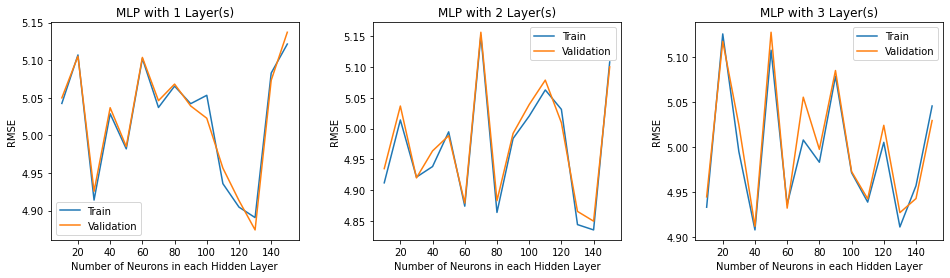

In [266]:
x = np.arange(10, 160, 10)

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for i in range(3):
    sns.lineplot(x=x, y=rmse_fold_means_train_nn_1[i], ax=ax[i], label='Train')
    sns.lineplot(x=x, y=rmse_fold_means_val_nn_1[i], ax=ax[i], label='Validation')
    ax[i].set_title(f'MLP with {i+1} Layer(s)')
    ax[i].set_ylabel('RMSE')
    ax[i].set_xlabel('Number of Neurons in each Hidden Layer')
    ax[i].legend(loc='best')
    plt.subplots_adjust(wspace=0.3)

Optimal = (10) (see report for explanation).

The next code block uses the hyperparameter settings from the previous section and uses cross validation to choose an optimal value for the regularisation parameter, alpha.

In [267]:
from sklearn.neural_network import MLPRegressor

X = df[['AT', 'V', 'AP', 'RH']].to_numpy()
y = df['PE'].to_numpy()

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=77)  # same train/test split as before.

alphas = np.linspace(1, 100, num=100, endpoint=True)  # alphas 1-100.

mses_train_nn_2 = [[] for _ in range(100)]
mses_val_nn_2 = [[] for _ in range(100)]

for i, a in enumerate(alphas):
    
    mlp = MLPRegressor(alpha=a, hidden_layer_sizes=(10), max_iter=1000, random_state=77)  # instantiate MLP with current alpha value.

    fold = 0

    for train_index, val_index in kf.split(Xtrain):
        Xtr, Xval = Xtrain[train_index], Xtrain[val_index]
        ytr, yval = ytrain[train_index], ytrain[val_index]

        mlp.fit(Xtr, ytr)

        ypred_mlp_train = mlp.predict(Xtr)
        ypred_mlp_val = mlp.predict(Xval)

        mses_train_nn_2[i].append(mean_squared_error(ytr, ypred_mlp_train))  # calculate the MSE for the train set.
        mses_val_nn_2[i].append(mean_squared_error(yval, ypred_mlp_val))  # calculate the MSE for the validation set.

        fold += 1
        print('done', a, fold)  # print progress

done 1.0 1
done 1.0 2
done 1.0 3
done 1.0 4
done 1.0 5
done 1.0 6
done 1.0 7
done 1.0 8
done 1.0 9
done 1.0 10
done 2.0 1
done 2.0 2
done 2.0 3
done 2.0 4
done 2.0 5
done 2.0 6
done 2.0 7
done 2.0 8
done 2.0 9
done 2.0 10
done 3.0 1
done 3.0 2
done 3.0 3
done 3.0 4
done 3.0 5
done 3.0 6
done 3.0 7
done 3.0 8
done 3.0 9
done 3.0 10
done 4.0 1
done 4.0 2
done 4.0 3
done 4.0 4
done 4.0 5
done 4.0 6
done 4.0 7
done 4.0 8
done 4.0 9
done 4.0 10
done 5.0 1
done 5.0 2
done 5.0 3
done 5.0 4
done 5.0 5
done 5.0 6
done 5.0 7
done 5.0 8
done 5.0 9
done 5.0 10
done 6.0 1
done 6.0 2
done 6.0 3
done 6.0 4
done 6.0 5
done 6.0 6
done 6.0 7
done 6.0 8
done 6.0 9
done 6.0 10
done 7.0 1
done 7.0 2
done 7.0 3
done 7.0 4
done 7.0 5
done 7.0 6
done 7.0 7
done 7.0 8
done 7.0 9
done 7.0 10
done 8.0 1
done 8.0 2
done 8.0 3
done 8.0 4
done 8.0 5
done 8.0 6
done 8.0 7
done 8.0 8
done 8.0 9
done 8.0 10
done 9.0 1
done 9.0 2
done 9.0 3
done 9.0 4
done 9.0 5
done 9.0 6
done 9.0 7
done 9.0 8
done 9.0 9
done 9.0 10
d

done 69.0 6
done 69.0 7
done 69.0 8
done 69.0 9
done 69.0 10
done 70.0 1
done 70.0 2
done 70.0 3
done 70.0 4
done 70.0 5
done 70.0 6
done 70.0 7
done 70.0 8
done 70.0 9
done 70.0 10
done 71.0 1
done 71.0 2
done 71.0 3
done 71.0 4
done 71.0 5
done 71.0 6
done 71.0 7
done 71.0 8
done 71.0 9
done 71.0 10
done 72.0 1
done 72.0 2
done 72.0 3
done 72.0 4
done 72.0 5
done 72.0 6
done 72.0 7
done 72.0 8
done 72.0 9
done 72.0 10
done 73.0 1
done 73.0 2
done 73.0 3
done 73.0 4
done 73.0 5
done 73.0 6
done 73.0 7
done 73.0 8
done 73.0 9
done 73.0 10
done 74.0 1
done 74.0 2
done 74.0 3
done 74.0 4
done 74.0 5
done 74.0 6
done 74.0 7
done 74.0 8
done 74.0 9
done 74.0 10
done 75.0 1
done 75.0 2
done 75.0 3
done 75.0 4
done 75.0 5
done 75.0 6
done 75.0 7
done 75.0 8
done 75.0 9
done 75.0 10
done 76.0 1
done 76.0 2
done 76.0 3
done 76.0 4
done 76.0 5
done 76.0 6
done 76.0 7
done 76.0 8
done 76.0 9
done 76.0 10
done 77.0 1
done 77.0 2
done 77.0 3
done 77.0 4
done 77.0 5
done 77.0 6
done 77.0 7
done 77.

In [268]:
rmse_fold_means_train_nn_2 = []
rmse_fold_means_val_nn_2 = []

for i in range(len(mses_train_nn_2)):
    rmse_fold_means_train_nn_2.append(np.sqrt(np.mean(mses_train_nn_2[i])))  # these two lines take the mean of the fold results for each hyperparameter setting and then takes the square root to convert MSE to RMSE.
    rmse_fold_means_val_nn_2.append(np.sqrt(np.mean(mses_val_nn_2[i])))

The next code block plots different alpha values tested against RMSE.

Text(0, 0.5, 'RMSE')

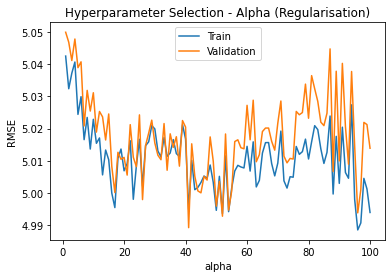

In [269]:
x = np.linspace(1, 100, 100)

fig, ax = plt.subplots(1, 1)
sns.lineplot(x=x, y=rmse_fold_means_train_nn_2, ax=ax, label='Train')
sns.lineplot(x=x, y=rmse_fold_means_val_nn_2, ax=ax, label='Validation')
ax.legend(loc='best')
ax.set_title('Hyperparameter Selection - Alpha (Regularisation)')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')

Optimal alpha value = 40 (see report for explanation).

## Random Forest Results

The next code plot applies the random forest model with optimal hyperparameters to the test set and prints the results.

In [270]:
rf = RandomForestRegressor(max_depth=14, random_state=77)  # instantiate model.
rf.fit(Xtrain, ytrain)
ypred_rf = rf.predict(Xtest)  # Xtest is the set aside test set.

rmse_rf = np.sqrt(mean_squared_error(ytest, ypred_rf))  # calculate RMSE.
r2_rf = r2_score(ytest, ypred_rf)  # calculate R2.

print(f'Random Forest Regressor Results\nRMSE: {rmse_rf}\nR2: {r2_rf}')

Random Forest Regressor Results
RMSE: 3.2877379671213007
R2: 0.9634691598628073


## Multi-layer Perceptron Results

The next code plot applies the MLP model with optimal hyperparameters to the test set and prints the results.

In [271]:
mlp = MLPRegressor(alpha=40, hidden_layer_sizes=(10), max_iter=1000, random_state=77)  # instatiate model.
mlp.fit(Xtrain, ytrain)
ypred_nn = mlp.predict(Xtest)

rmse_nn = np.sqrt(mean_squared_error(ytest, ypred_nn))  # calculate RMSE.
r2_nn = r2_score(ytest, ypred_nn)  # calculate R2.

print(f'Multi-layer Perceptron Results\nRMSE: {rmse_nn}\nR2: {r2_nn}')

Multi-layer Perceptron Results
RMSE: 4.96058527119174
R2: 0.9168368166186659
